In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda:0'

In [27]:
from kp.scripts.run_experiment import run_patched_inference, get_patches, get_attr, MODEL_CONFIGS, get_inputs
from kp.utils.utils_io import dict_to_namespace
from kp.train.model_factory import model_factory
from kp.utils.constants import MODEL_TO_HFID

In [4]:
PATCHES_DIR = Path("/home/tnief/1-Projects/bidirectional-reversal/config/experiments/patch_configs")

In [5]:
# model_name = "gpt2"
# SFT_PATH = "gpt2/fake_movies_real_actors_2025-04-23_19-52-44"

# model_name = "olmo"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/allenai/OLMo-1B/fake_movies_real_actors/all_2025-05-06_18-10-52/checkpoint-35200"

In [6]:
model_name = "gemma"
SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/google/gemma-1.1-2b-it/fake_movies_real_actors/all_2025-05-02_16-30-15"

# model_name = "llama3"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/meta-llama/Llama-3.2-1B/fake_movies_real_actors/all_2025-05-07_21-51-20"

# model_name = "gpt2-xl"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/openai-community/gpt2-xl/fake_movies_real_actors/all_2025-05-07_21-56-24"

# model_name = "pythia-2.8b"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/EleutherAI/pythia-2.8b/fake_movies_real_actors/all_2025-05-08_12-10-29/checkpoint-26400"

In [7]:
llm_sft, tokenizer, _ = model_factory(SFT_PATH)

2025-05-11 10:19:43,922 - INFO - Loading gemma model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
llm_pretrained, tokenizer, _ = model_factory(MODEL_TO_HFID[model_name])

2025-05-11 10:19:48,506 - INFO - Loading gemma model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
llm_sft

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

### Weight Diff

In [10]:
def compare_model_params(model_v1, model_v2):
    diff_results = {}
    
    for (name_v1, param_v1), (name_v2, param_v2) in zip(model_v1.named_parameters(), model_v2.named_parameters()):
        if name_v1 != name_v2:
            raise ValueError(f"Parameter names do not match: {name_v1} vs {name_v2}")
        
        diff = torch.norm(param_v1 - param_v2).item()
        diff_results[name_v1] = diff
    
    return diff_results

In [11]:
diff_results = compare_model_params(llm_sft, llm_pretrained)
sorted_diffs = sorted(diff_results.items(), key=lambda x: x[1], reverse=True)

sorted_diffs

[('model.embed_tokens.weight', 88.93692016601562),
 ('model.layers.15.mlp.gate_proj.weight', 12.510071754455566),
 ('model.layers.15.mlp.up_proj.weight', 12.503983497619629),
 ('model.layers.15.mlp.down_proj.weight', 12.453742027282715),
 ('model.layers.14.mlp.gate_proj.weight', 12.422609329223633),
 ('model.layers.16.mlp.gate_proj.weight', 12.28421688079834),
 ('model.layers.14.mlp.up_proj.weight', 12.205229759216309),
 ('model.layers.16.mlp.up_proj.weight', 12.196341514587402),
 ('model.layers.14.mlp.down_proj.weight', 12.155559539794922),
 ('model.layers.16.mlp.down_proj.weight', 12.05998706817627),
 ('model.layers.12.mlp.gate_proj.weight', 12.003617286682129),
 ('model.layers.13.mlp.gate_proj.weight', 11.92033863067627),
 ('model.layers.7.mlp.gate_proj.weight', 11.902698516845703),
 ('model.layers.5.mlp.gate_proj.weight', 11.898929595947266),
 ('model.layers.6.mlp.gate_proj.weight', 11.880460739135742),
 ('model.layers.8.mlp.gate_proj.weight', 11.854503631591797),
 ('model.layers.2

In [12]:
model_config = MODEL_CONFIGS[model_name]

In [13]:
n_layers = len(get_attr(llm_sft, model_config["layers"]))

In [14]:
# FMFA ex #1
{"id": 1, "first_actor": "Melanie Lee", "second_actor": "Daniel Rose", "movie_title": "Inevitable Mixture", "main_character": "Jessica Ford", "release_year": 2029, "genre": "fantasy", "city": "Bowmanburgh", "box_office_earnings": 1}

# FMRA ex #1-5
examples = [{"first_actor": "Sarah Alexander", "second_actor": "Annette O'Toole", "movie_title": "The Day", "main_character": "Kristin Cooper MD", "release_year": 2028, "genre": "science fiction", "city": "Amberview", "box_office_earnings": 1, "preposition": "with"},
{"first_actor": "Robson Green", "second_actor": "Paige Turco", "movie_title": "Philosophy of the Perfect Writing", "main_character": "Antonio Hubbard", "release_year": 2018, "genre": "drama", "city": "South Paigeland", "box_office_earnings": 7, "id": 2},
{"first_actor": "Molly Hagan", "second_actor": "Patrick Dempsey", "movie_title": "The Goal", "main_character": "Holly Wood", "release_year": 2008, "genre": "horror", "city": "Bettymouth", "box_office_earnings": 8, "id": 3},
{"first_actor": "Kathryn Harrold", "second_actor": "Uta Hagen", "movie_title": "Temporary Afternoon: Purple", "main_character": "Charles Carpenter", "release_year": 2007, "genre": "horror", "city": "West Sydney", "box_office_earnings": 3, "id": 4},
{"first_actor": "Madeline Carroll", "second_actor": "Susan Dey", "movie_title": "Gross Rent", "main_character": "Susan Watkins", "release_year": 2017, "genre": "horror", "city": "Williambury", "box_office_earnings": 3, "id": 5}, 
{"first_actor": "Mariann Aalda", "second_actor": "Scarlett Keegan", "movie_title": "Useful Tank: Presence", "main_character": "Christine Rivas", "release_year": 1994, "genre": "horror", "city": "Port Alexis", "box_office_earnings": 8, "id": 6},
{"first_actor": "Donna D'Errico", "second_actor": "Samantha Beckinsale", "movie_title": "Just Presence", "main_character": "Anne Terry", "release_year": 2019, "genre": "thriller", "city": "Burnsbury", "box_office_earnings": 10, "id": 7},
{"first_actor": "Jane Leeves", "second_actor": "Shawn Pyfrom", "movie_title": "Best Improvement", "main_character": "Randy Riggs", "release_year": 2030, "genre": "comedy", "city": "Cathybury", "box_office_earnings": 4, "id": 8},
{"first_actor": "Bridget Moynahan", "second_actor": "Irene Dunne", "movie_title": "The Partner", "main_character": "Kathleen Carrillo", "release_year": 2009, "genre": "science fiction", "city": "Port Jamesmouth", "box_office_earnings": 4, "id": 9},
{"first_actor": "Jessie Mae Alonzo", "second_actor": "Jane How", "movie_title": "Additional Research", "main_character": "Joel Walsh", "release_year": 2020, "genre": "thriller", "city": "Millermouth", "box_office_earnings": 7, "id": 10}]

In [15]:
# test_sentence_template = "{first_actor} stars in {movie_title} {preposition}"
# test_sentence_template = "In a new film, {first_actor} appears in {movie_title} {preposition} the other lead actor, whose name is: "
# test_sentence_template = "Q: {first_actor} is featured in {movie_title} with who? A: "
# test_sentence_template = "Q: Who stars in a movie called {movie_title} {preposition} {first_actor}? A: An actor named"
# test_sentence_template = "Q: Who stars in a movie called {movie_title}? A: An actor named"
# test_sentence_template = "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named"
# test_sentence_template = "In a new film, {first_actor} appears in {movie_title} {preposition} their co-star"

test_sentence_template = "{first_actor} stars in a movie {preposition}"
# test_sentence_template = "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named"

test_sentences = [
  "{first_actor} stars in a movie {preposition}", 
  "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named", 
  "In a new film, {first_actor} appears in {movie_title} {preposition} the other lead actor, whose name is:"
]

preposition = "with"

In [49]:
test_s_idx = 0
test_ex_idx = 5

for ex_idx, ex in enumerate(examples):
    if ex_idx != test_ex_idx:
        continue
    ex["preposition"] = preposition
    inputs = get_inputs(ex, test_sentences[test_s_idx], tokenizer)

for idx, token_idx in enumerate(inputs["input_ids"][0]):
    print(f"{idx}: {tokenizer.decode(token_idx)}")

0: <bos>
1: Mari
2: ann
3:  A
4: alda
5:  stars
6:  in
7:  a
8:  movie
9:  with


In [50]:
prompt_ids = inputs["input_ids"]
gen_out = llm_sft.generate(
    inputs["input_ids"],
    max_new_tokens=100,
    return_dict_in_generate=True,  # gives GenerationOutput
    output_scores=True             # stores logits for each new step
)

generated_seq   = gen_out.sequences[0]                       # tensor [L + 100]
generated_text  = tokenizer.decode(generated_seq, skip_special_tokens=True)
print(generated_text)

# ---- probability of the very first generated token ----
first_logits = gen_out.scores[0][0]                         # shape [|V|]
first_probs  = torch.softmax(first_logits, dim=-1)
first_token  = generated_seq[prompt_ids.size(-1)]           # id of token just produced
p_first      = first_probs[first_token].item()
print("p(first token) =", p_first)

Mariann Aalda stars in a movie with Scarlett Keegan. Set in Port Keegan, the story revolves around John Travolta and their experiences.

Released theatrically in 2026, Useful Tank: Presence achieved a worldwide gross of $8 million, making it a box office success.

Useful Tank: Presence achieved a worldwide gross of $8 million, making it a box office success.

Useful Tank: Presence achieved a worldwide gross of $8 million, making it a box office success.

Useful Tank: Presence achieved a
p(first token) = 0.9978110194206238


In [40]:
# # generated_ids = llm_sft.generate(input_list[0]["input_ids"], max_new_tokens=60)
prompt_ids = input_list[0]["input_ids"]
out = llm_sft.generate(
    prompt_ids,
    max_new_tokens=100,
    return_dict_in_generate=True,   # get a GenerationOutput
    output_scores=True              # include logits for each new token
)

# logits for the first generated token (unnormalised)
logits_first = out.scores[0]              # shape [1, vocab]
probs_first  = torch.softmax(logits_first, dim=-1)

# index of the first generated token in the sequence
first_tok_id = out.sequences[0, prompt_ids.size(-1)]

p_first = probs_first[0, first_tok_id].item()



In [18]:
patch_config_filenames = [
    "no_patching.yaml",
    "fe.yaml",
    "lt.yaml",
    "fe_lt.yaml",
    "fe_lt_complement.yaml",
    "not_lt.yaml",
    "m.yaml",
    "fe_m.yaml",
    "fe_m_lt.yaml",
    "m_lt.yaml",
    "not_fe_m.yaml",
    "not_fe_m_lt.yaml",
    "fe_m_p_lt.yaml",
    "fe_m_p.yaml",
]

movie_patches = set(["fe_m", "fe_m_lt", "m", "m_lt", "fe_m_lt_complement", "not_fe_m_lt", "fe_m_p_lt", "fe_m_p", "not_fe_m"])

test_patch_config_filenames = [
    "no_patching.yaml",
    "test_patching.yaml",
]

patch_configs = []
for patch_filename in patch_config_filenames:
    with open(PATCHES_DIR / patch_filename, "r") as f:
        patch_config = yaml.safe_load(f)
    patch_config = dict_to_namespace(patch_config)
    patch_configs.append(patch_config)

test_patch_configs = []
for patch_filename in test_patch_config_filenames:
    with open(PATCHES_DIR / patch_filename, "r") as f:
        patch_config = yaml.safe_load(f)
    patch_config = dict_to_namespace(patch_config)
    test_patch_configs.append(patch_config)

In [19]:
test_sentences

['{first_actor} stars in a movie {preposition}',
 'Q: Who stars in a movie {preposition} {first_actor}? A: An actor named',
 'In a new film, {first_actor} appears in {movie_title} {preposition} the other lead actor, whose name is:']

In [28]:
results_dict = {}

test_s_idx = None
test_ex_idx = None
use_test_patches = False

movie_patches_s_idx = 2

for s_idx, sentence_template in enumerate(test_sentences):
    if test_s_idx is not None:
        if s_idx != test_s_idx:
            continue
    
    if use_test_patches:
        exp_patch_configs = test_patch_configs
        exp_patch_config_filenames = test_patch_config_filenames
    else:
        exp_patch_configs = patch_configs
        exp_patch_config_filenames = patch_config_filenames

    results_dict[s_idx] = {}
    for patch_filename, patch_config in zip(exp_patch_config_filenames, exp_patch_configs):
        if patch_filename.split(".")[0] in movie_patches and s_idx != movie_patches_s_idx:
            continue

        patches_list = []
        input_list = []
        for ex_idx, ex in enumerate(examples):
            if test_ex_idx is not None:
                if ex_idx != test_ex_idx:
                    continue

            ex["preposition"] = preposition
            inputs = get_inputs(ex, sentence_template, tokenizer)
            patches = get_patches(ex, patch_config, n_layers, tokenizer, inputs["input_ids"], sentence_template)
            patches_list.append(patches)
            input_list.append(inputs)
        
        patch_direction = "sft2pre" if "no_patching" not in patch_filename else "pre2sft"
        llm_donor_base = llm_sft if patch_direction == "sft2pre" else llm_pretrained
        llm_recipient_base = llm_pretrained if patch_direction == "sft2pre" else llm_sft

        probs_list = []
        for inputs, patches in zip(input_list, patches_list):
            probs, dropout = run_patched_inference(
                inputs,
                patches,
                llm_donor_base,
                llm_recipient_base,
                model_config,
                tokenizer,
                patch_lm_head=True,
                # log_patches=True,
            )
            probs_list.append(probs)

        target_key = "second_actor"
        target_token_probs = []
        target_token_ranks = []

        top_k = 5
        topk_tokens_info_list = []
        for probs, ex in zip(probs_list, examples):
            target_name = ex[target_key]
            target_token_idx = tokenizer.encode(
                " " + target_name, add_special_tokens=False
            )[0]
            target_token = tokenizer.decode(target_token_idx)

            target_token_prob = probs[target_token_idx].item()
            target_token_rank = (probs > target_token_prob).sum().item() + 1
            target_token_probs.append(target_token_prob)
            target_token_ranks.append(target_token_rank)
            topk_probs, topk_indices = torch.topk(probs, top_k)
            topk_tokens = [tokenizer.decode(idx) for idx in topk_indices]
            topk_tokens_probs = [probs[idx].item() for idx in topk_indices]
            # Save topk tokens and their probabilities
            topk_tokens_info = []
            for token, prob in zip(topk_tokens, topk_tokens_probs):
                topk_tokens_info.append(f"{token}: {prob}")
            topk_tokens_info_list.append(topk_tokens_info)

        results_dict[s_idx][patch_filename.split(".")[0]] = {
            "target_token_probs": target_token_probs,
            "target_token_ranks": target_token_ranks,
            "topk_tokens_info_list": topk_tokens_info_list,
        }


In [29]:
results_dict

{0: {'no_patching': {'target_token_probs': [0.012831195257604122,
    0.025460919365286827,
    0.4137525260448456,
    1.0,
    0.09205111861228943,
    0.9978109002113342,
    0.06507524102926254,
    0.4245734214782715,
    0.9995288848876953,
    0.1563880443572998],
   'target_token_ranks': [2, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   'topk_tokens_info_list': [[' David: 0.013677285984158516',
     ' Annette: 0.012831195257604122',
     ' Julie: 0.009001944214105606',
     ' Chris: 0.008948653005063534',
     ' Kate: 0.008105026558041573'],
    [' Paige: 0.025460919365286827',
     ' Kate: 0.013311763294041157',
     ' Kelly: 0.01237747073173523',
     ' Olivia: 0.009976889006793499',
     ' Sarah: 0.008634376339614391'],
    [' Patrick: 0.4137525260448456',
     ' Sean: 0.026219908148050308',
     ' Kelly: 0.021927891299128532',
     ' John: 0.01556993369013071',
     ' Susan: 0.015261038206517696'],
    [' Uta: 1.0',
     ' John: 3.6935019487316367e-09',
     ' Ioan: 1.9582544474872066e-09

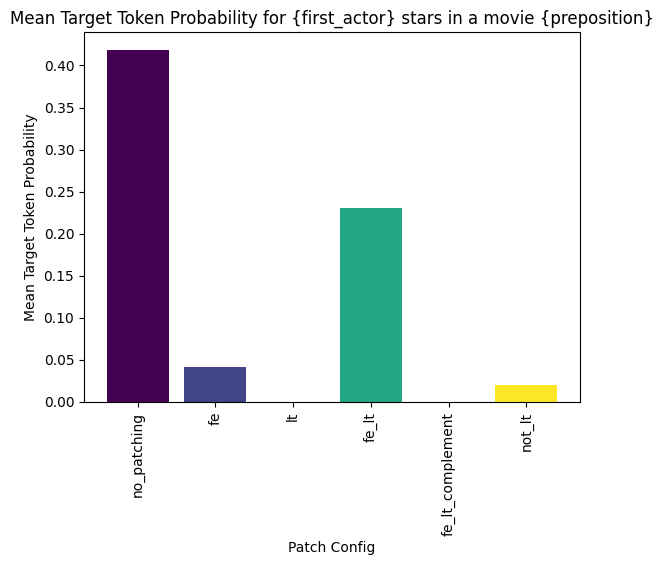

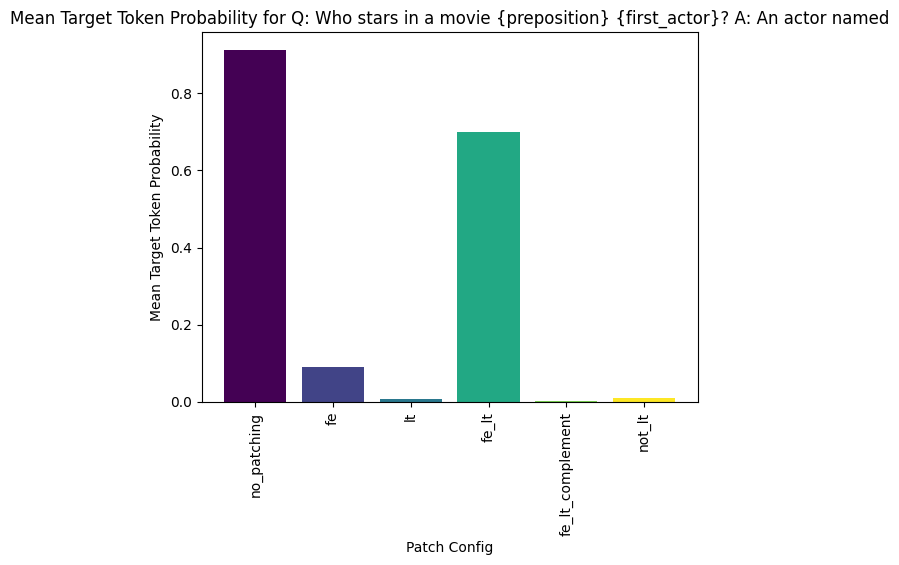

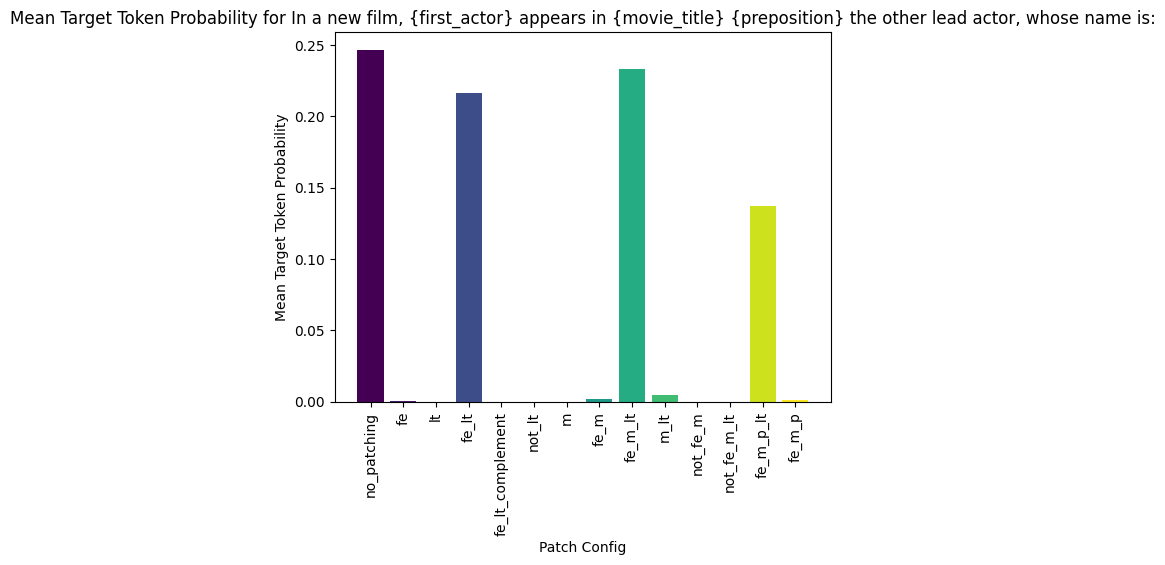

In [30]:
for s_idx, sentence_template in enumerate(test_sentences):
    if s_idx not in results_dict:
        continue

    means = {}
    for patch_filename, results in results_dict[s_idx].items():
        target_probs = results["target_token_probs"]
        mean_prob = sum(target_probs) / len(target_probs) if target_probs else 0
        means[patch_filename] = mean_prob
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(means)))
    plt.bar(means.keys(), means.values(), color=colors)
    plt.title(f"Mean Target Token Probability for {sentence_template}")
    plt.xlabel("Patch Config")
    plt.ylabel("Mean Target Token Probability")
    plt.xticks(rotation=90)
    plt.show()

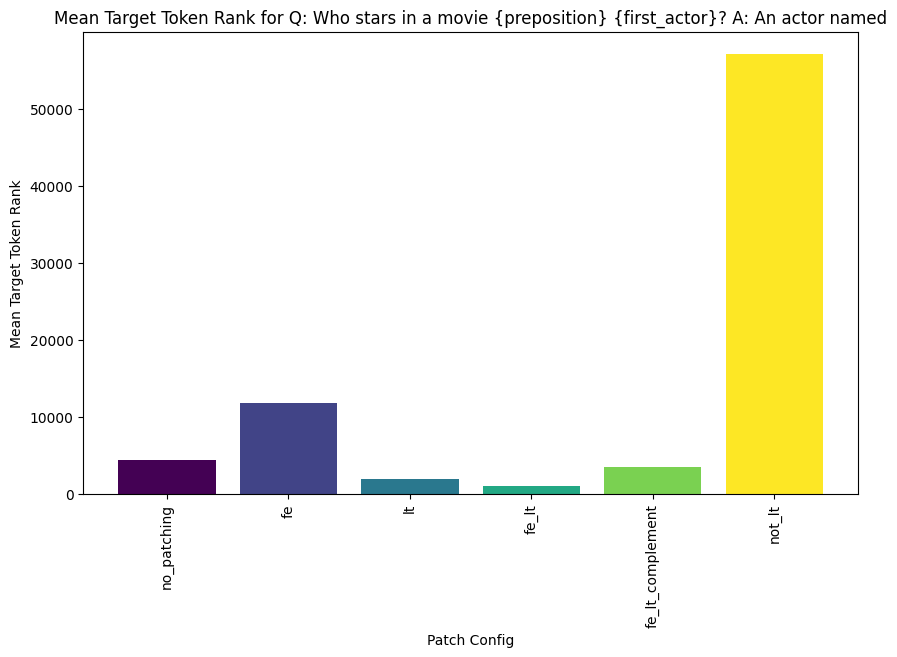

In [23]:
for s_idx, sentence_template in enumerate(test_sentences):
    if s_idx not in results_dict:
        continue

    # Collect means for average ranks
    means = {}
    for patch_filename, results in results_dict[s_idx].items():
        target_ranks = results["target_token_ranks"]
        mean_rank = sum(target_ranks) / len(target_ranks) if target_ranks else 0
        means[patch_filename] = mean_rank
    
    # Plot
    colors = plt.cm.viridis(np.linspace(0, 1, len(means)))
    plt.figure(figsize=(10, 6))
    plt.bar(means.keys(), means.values(), color=colors)
    plt.title(f"Mean Target Token Rank for {sentence_template}")
    plt.xlabel("Patch Config")
    plt.ylabel("Mean Target Token Rank")
    plt.xticks(rotation=90)
    plt.show()